---
title: 极客时间-现代C++30讲 03 | 右值和移动究竟解决了什么？
tags: 小书匠,C++,极客时间-现代C++30讲,lvalue,rvalue,reference,move,forward
grammar_cjkRuby: true
# renderNumberedHeading: true
---

[toc]

# 极客时间-现代C++30讲 03 | 右值和移动究竟解决了什么？

## Taxonomy of expressions（value categories)

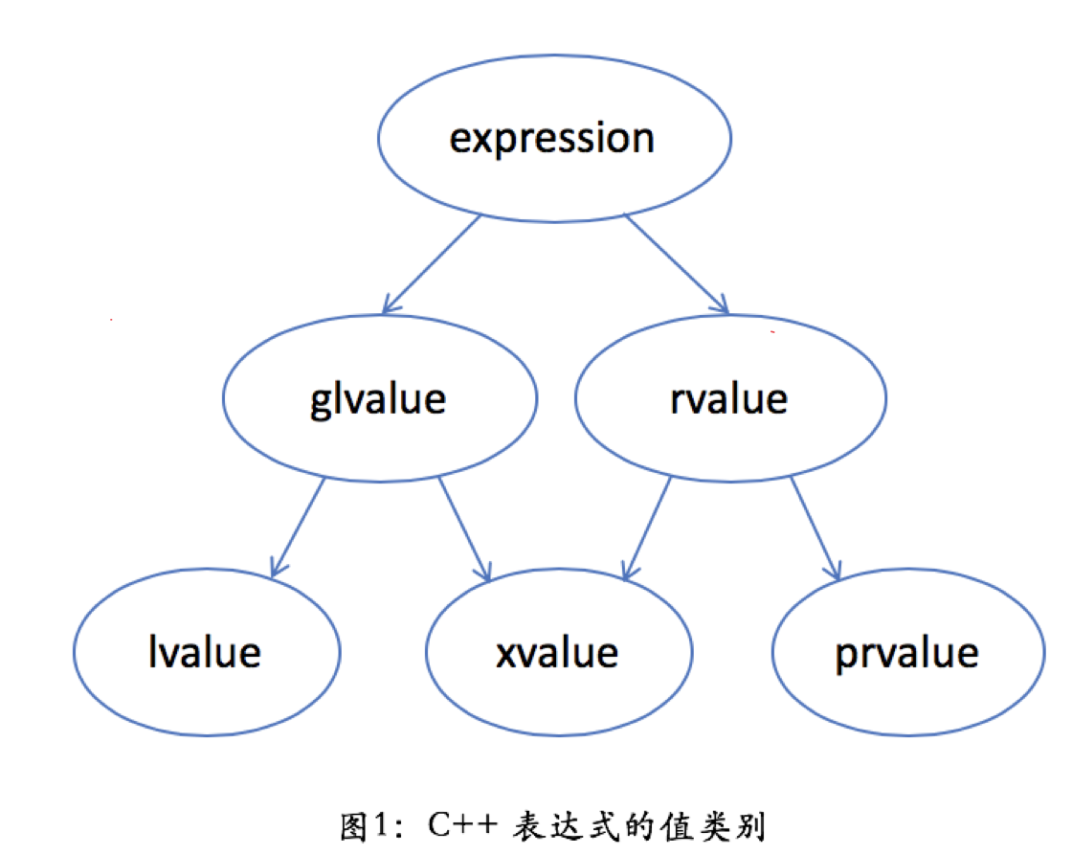

Lvalue, xvalue and prvalue are primary categories, while glvalue and rvalue are called mixed categories.

- Primary categories
    - lvalue: left value. A value with an identifier and can be taken address
    - prvalue: pure right value. A value without identifier and can not be taken address.
    - xvalue: expiring value
- Mixed categories
    - glvalue: generalized lvalue, including lvalue and xvalue.
    - rvalue: right value, including xvalue and glvalue.

Value categories can be defined by 2 aspects
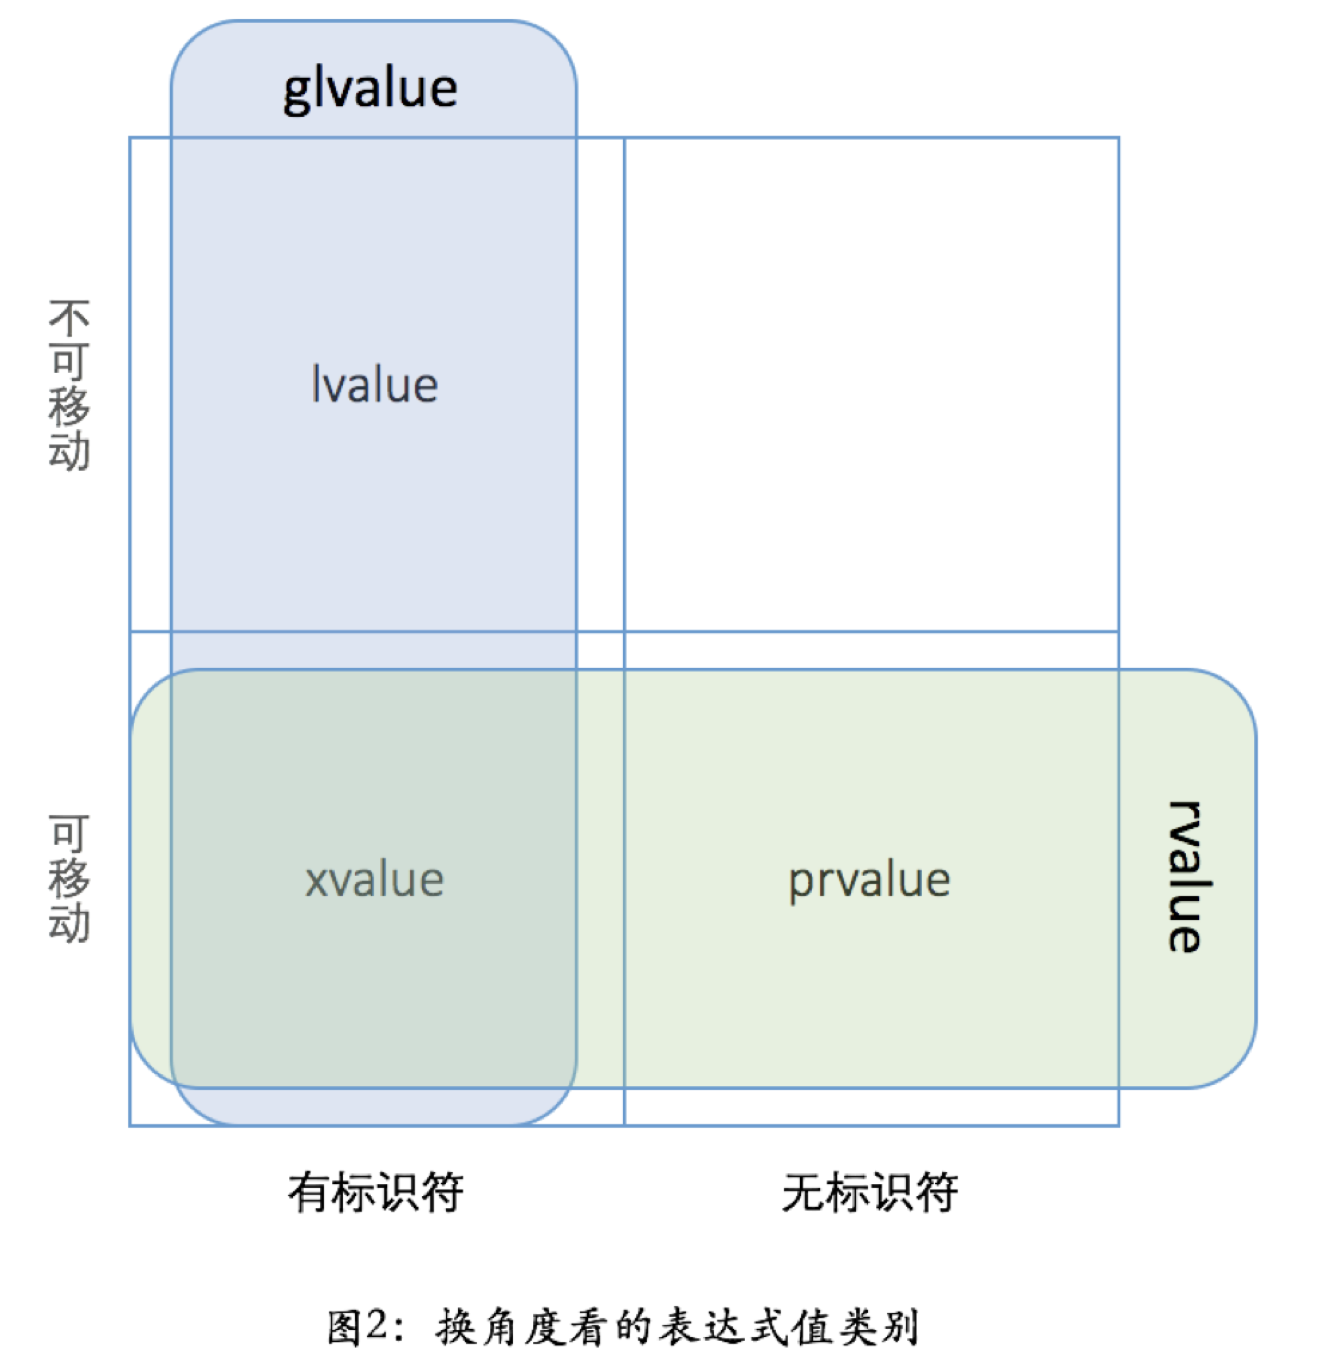

See [Value categories - cppreference.com](https://en.cppreference.com/w/cpp/language/value_category) for more details 

## Optimization when returning by value

In [8]:
%%file test.cpp
#include <iostream>

using std::cout;
using std::endl;

class circle 
{
    public:
        circle() { cout << "circle()" << endl; }
        ~circle() { cout << "~circle()" << endl; }
};

class result 
{
    public:
        result() { cout << "result()" << endl; }
        ~result() { cout << "~result()" << endl; }
        result(const result& r) { cout << "result(const result& r)" << endl; }
};

result process_result(const circle& s)
{
   return result();   // compilers will optimize here when returning by value
}

int main()
{
    process_result(circle());
    return 0;
}

Overwriting test.cpp


In [10]:
!g++ test.cpp -o test && ./test

circle()
result()
~result()
~circle()


As the results show, only one circle object and one result object are constructed and destructed. Without optimization, conceptually there will be two cricle() constructed: one is the result object constructed in process_result, the other is the copy of result object when returning.

In [12]:
%%file test.cpp
#include <iostream>

using std::cout;
using std::endl;

class circle
{
    public:
        circle() { cout << "circle()" << endl; }
        ~circle() { cout << "~circle()" << endl; }
};

class result 
{
    public:
        result() { cout << "result()" << endl; }
        ~result() { cout << "~result()" << endl; }
        result(const result& r) { cout << "result(const result& r)" << endl; }
};

result process_result(const circle& s)
{
   return std::move(result());  // using std::move here will not help returning optimization
                                // instead, it even prevents compilers returning optimization
}

int main()
{
    process_result(circle());
    return 0;
}

Overwriting test.cpp


In [13]:
!g++ test.cpp -o test && ./test

circle()
result()
result(const result& r)
~result()
~result()
~circle()


The only difference between previous code and this one is that process_result returns `std::move(result())` instead of `result()`. The purpose of using `std::move` may be help 

## rvalue reference

### An rvalue reference is an lvalue

**What is not intuitive is that an rvalue reference itself is an lvalue**, as the following code illustrates.

In [60]:
%%file test.cpp
#include <iostream>

using namespace std;

// Two versions of print are provided. One expects an lvalue as an argument and the other expects an rvalue.
void print(int& x)
{
    cout << "print(int& x)" << endl;
}

void print(int&& x)
{
    cout << "print(int&& x)" << endl;
}

int main()
{
    int&& ref = 24;
    cout << "print(24): ";
    print(24);
    cout << "print(ref): ";
    print(ref);
    return 0;
}

Overwriting test.cpp


In [61]:
!g++ test.cpp -o test && ./test

print(24): print(int&& x)
print(ref): print(int& x)


The results show call to `print(24)` will invoke `print(int&&x)` because literal `24` is an rvalue, whereas the call to `print(ref)` will invoke `print(int& x)` because rvalue reference `ref` is an lvalue.

Sometimes, this property of rvalue reference is not suitable and that's the reason for std::forward being introduced

### rvalue reference and const lvalue reference

Before the existence of rvalue reference, if we want to pass an rvalue as an argument, we need to use a `const lvalue reference` as a parameter.

In [69]:
const int& a = 24; // const int&. valid

The main difference between rvalue and const lvalue reference is modifiability. A `const lvalue reference` cannot be modified while an rvalue reference can.

In [72]:
const int& a = 24;
int&& b = 24;
// a += 1; // invalid
b += 1; // valid

25

### rvalue references can extend the lifetime of prvalues

Here is an example explaining the lifetime of prvalues.

In [139]:
%%file test.cpp
#include <iostream>
using namespace std;
class A
{
    public:
        A() { cout << "A()" << endl;}
        ~A() { cout << "~A()" << endl;}
};

A getA()
{
    return A();
}

int main()
{
    getA(); 
    // the result value of getA() is destructed before here
    cout << "before main exits" << endl;
    return 0;
}

Overwriting test.cpp


In [140]:
!g++ test.cpp -o test && ./test

A()
~A()
before main exits


The results show that the result of getA() is destructed before print message of `"before main exits"`.

In [141]:
%%file test.cpp
#include <iostream>
using namespace std;
class A
{
    public:
        A() { cout << "A()" << endl;}
        ~A() { cout << "~A()" << endl;}
};

A getA()
{
    return A();
}

int main()
{
    A&& ref = getA();
    cout << "before main exits" << endl;
    return 0;
}

Overwriting test.cpp


In [142]:
!g++ test.cpp -o test && ./test

A()
before main exits
~A()


Here, the call to `~A()` is after `before main exits` part, indictating that the object ref referenced to lives until the `main()` returns.

#### rvalue references cannot extend the lifetime of xrvalues.

In [137]:
%%file test.cpp
#include <iostream>
using namespace std;
class A
{
    public:
        int data;
        A(): data(-1) { cout << "A()" << endl;}
        ~A() { cout << "~A()" << endl;}
};

A getA()
{
    return A();
}

int main()
{
    A&& ref = std::move(getA()); // std::move(getA()) is an xvalue
    cout << "before main exits" << endl;
    cout << ref.data << endl;
    return 0;
}

Overwriting test.cpp


In [138]:
!g++ test.cpp -o test && ./test

A()
~A()
before main exits
-1


The results show that the result of `getA()` is destroyed before printing the message of "before main exists", indicating that rvalue references cannot extend the lifetime of xvalues. 

The strange thing is that, even if the object is destroyed, when we call `cout << ref.data << endl`, the program still prints the result of -1 correctly.

The reason may be that the `ref` references to the memory on stack instead of on heap, making the bug caused by an rvalue reference referencing to an xvalue difficult to see.

## Reference collapsing and forward

### Reference collapsing

See [C++ reference collapsing 引用折叠](evernote:///view/22483756/s54/84f620c3-0445-44a5-b3c7-39f1a16f8671/84f620c3-0445-44a5-b3c7-39f1a16f8671/) for more details

### forward

Suppose we have function foo with two versions: `foo(const string&)` and `foo(string&&)`. And we have another function `bar` calling `foo`. Because there are two versions of `foo`, we want to support two versions of `bar` according to which version of `foo` is used.

In [48]:
%%file test.cpp
#include <iostream>
#include <string>
using namespace std;
void foo(const string&) { cout << "foo(const string&)" << endl; }
void foo(string&&) { cout << "foo(string&&)" << endl; }
void bar(const string& s) {
    cout << "bar(const string& s)" << endl; 
    foo(s);
}
void bar(string&& s) { 
    cout << "bar(string&& s)" << endl; 
    foo(std::move(s));  // std::move is required or foo(const string&) instead of rvalue version foo(string&&) is invoked
                        // because s is an rvalue reference and is an lvalue.
}
int main()
{
    bar(string());
    string s;
    bar(s);
    return 0;
}

Overwriting test.cpp


In [49]:
!g++ test.cpp -o test && ./test

bar(string&& s)
foo(string&&)
bar(const string& s)
foo(const string&)


#### Using reference collapsing

The question here is, although `bar(const string& s)` and `bar(string& s)` do almost the same things, because we want to support both versions of `foo`, we need to write both versions of `bar`, resulting in code duplication.

Here, we expect a template of `bar` that can accepts both `const string&` and `string&&` as an argument, where the reference collapsing comes in.

In [65]:
%%file test.cpp
#include <iostream>
#include <string>

using namespace std;
void foo(const string&) { cout << "foo(const string&)" << endl; }
void foo(string&&) { cout << "foo(string&&)" << endl; }

template<typename T>
void bar(T&& s) {
    foo(s); // Here needs improvement
}

int main()
{
    bar(string());
    string s;
    bar(s);
    return 0;
}

Overwriting test.cpp


In [66]:
!g++ test.cpp -o test && ./test

foo(const string&)
foo(const string&)


The results are still not as expected, because no matter what type of result foo(s) returns, s is an lvalue, then `foo(const string&)` will be invoked. `foo(string&&)` will never be invoked.

#### Using forward

The problem of the previous code is that rvalue reference s is an lvalue, while we want s to remain its value type unchanged. Namely, if s is an lvalue reference, s is expected to be passed as an lvalue into `foo`, while if s is an rvalue reference, s is expected to be passed as an rvalue into `foo`. This is where `std::forward` comes in.

In [67]:
%%file test.cpp
#include <iostream>
#include <string>
using namespace std;
void foo(const string&) { cout << "foo(const string&)" << endl; }
void foo(string&&) { cout << "foo(string&&)" << endl; }

template<typename T>
void bar(T&& s) {
    foo(forward<T>(s)); // use forward to remain the value type of s unchange
}

int main()
{
    bar(string());
    string s;
    bar(s);
    return 0;
}

Overwriting test.cpp


In [143]:
!g++ test.cpp -o test && ./test

A()
before main exits
~A()


# References 
2. [Value categories - cppreference.com](https://en.cppreference.com/w/cpp/language/value_category)